In [1]:
import gc
import multiprocessing
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as prfs, accuracy_score
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

In [2]:
df = pd.read_csv("../curated-data/CorrelationData.csv")
df.head(5)

,Rank,NASA,TA,EXT,AGR,CS,NT,OP,AV,EM,...,BR,NP,FA,SR,AP,AR,DWH,DWR,T,DS
0,Professor,24,38,2,8,10,3,8,16,17,...,2,2.0,1.0,1,2.0,4.0,2.0,70.0,1.0,1.0
1,Associate Professor,17,35,6,9,7,4,8,25,14,...,2,2.0,1.0,1,2.0,5.0,2.0,70.0,1.0,1.0
2,Assistant Professor,20,38,8,8,6,5,7,19,22,...,1,1.0,2.0,1,2.0,4.0,2.0,90.0,2.0,2.0
3,Assistant Professor,16,54,3,7,3,9,6,23,24,...,1,2.0,1.0,0,2.0,2.0,2.0,60.0,1.0,2.0
4,Professor,18,28,6,4,10,3,8,13,12,...,1,1.0,2.0,1,2.0,5.0,1.0,60.0,2.0,1.0


In [4]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df.Rank = label_encoder.fit_transform(df.Rank)
df.head(5)

,Rank,NASA,TA,EXT,AGR,CS,NT,OP,AV,EM,...,BR,NP,FA,SR,AP,AR,DWH,DWR,T,DS
0,2,24,38,2,8,10,3,8,16,17,...,2,2.0,1.0,1,2.0,4.0,2.0,70.0,1.0,1.0
1,1,17,35,6,9,7,4,8,25,14,...,2,2.0,1.0,1,2.0,5.0,2.0,70.0,1.0,1.0
2,0,20,38,8,8,6,5,7,19,22,...,1,1.0,2.0,1,2.0,4.0,2.0,90.0,2.0,2.0
3,0,16,54,3,7,3,9,6,23,24,...,1,2.0,1.0,0,2.0,2.0,2.0,60.0,1.0,2.0
4,2,18,28,6,4,10,3,8,13,12,...,1,1.0,2.0,1,2.0,5.0,1.0,60.0,2.0,1.0


In [8]:
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer()
imputed_df = pd.DataFrame(my_imputer.fit_transform(df))
imputed_df.columns = df.columns

In [9]:
imputed_df.describe()

,Rank,NASA,TA,EXT,AGR,CS,NT,OP,AV,EM,...,BR,NP,FA,SR,AP,AR,DWH,DWR,T,DS
count,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,...,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000
mean,1.263027,21.960298,41.322581,5.985112,7.511166,8.354839,5.456576,7.513648,18.870968,18.342432,...,1.471464,1.889764,1.900262,0.297767,1.813648,3.446194,1.871391,63.910761,1.538058,1.677165
std,0.810563,5.637332,10.227276,2.204648,1.650192,1.630141,2.144059,1.777887,5.094942,6.287226,...,0.499806,0.765178,1.459409,0.457845,0.379083,1.221844,0.325905,17.974067,0.485353,0.455184
min,0.000000,6.000000,20.000000,2.000000,3.000000,3.000000,2.000000,2.000000,7.000000,7.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,18.000000,34.000000,4.000000,6.000000,7.000000,4.000000,6.000000,15.000000,14.000000,...,1.000000,1.000000,1.000000,0.000000,2.000000,2.000000,2.000000,60.000000,1.000000,1.000000
50%,1.000000,22.000000,41.000000,6.000000,8.000000,9.000000,5.000000,8.000000,19.000000,18.000000,...,1.000000,2.000000,1.000000,0.000000,2.000000,3.446194,2.000000,70.000000,2.000000,2.000000
75%,2.000000,26.000000,49.000000,8.000000,9.000000,10.000000,7.000000,9.000000,22.000000,23.000000,...,2.000000,2.000000,2.000000,1.000000,2.000000,5.000000,2.000000,80.000000,2.000000,2.000000
max,2.000000,40.000000,70.000000,10.000000,10.000000,10.000000,10.000000,10.000000,33.000000,34.000000,...,2.000000,3.000000,6.000000,1.000000,2.000000,5.000000,2.000000,100.000000,2.000000,2.000000


<AxesSubplot:>

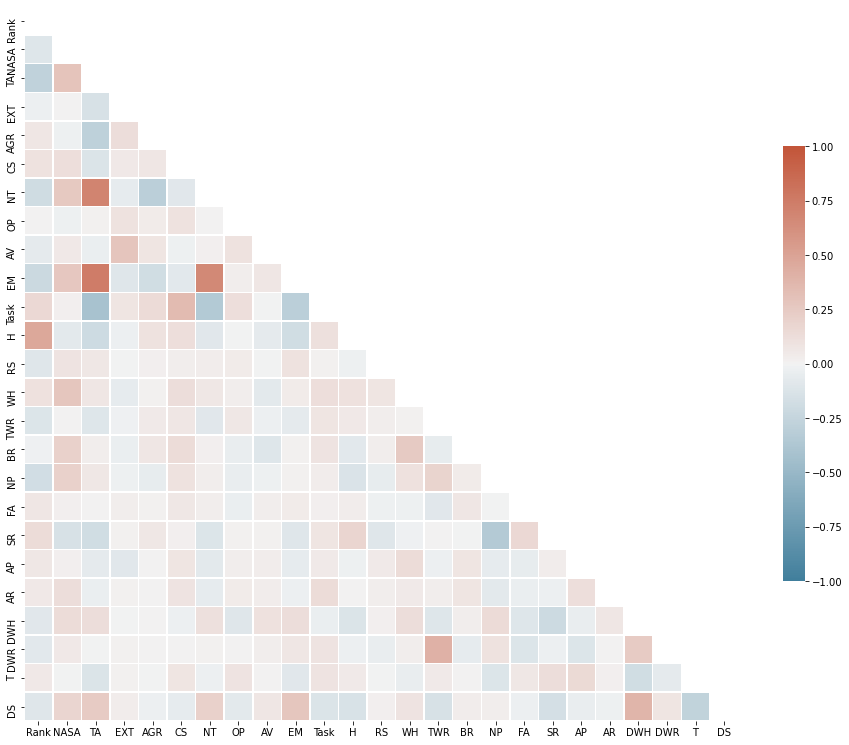

In [10]:
corr = imputed_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(imputed_df, imputed_df['SR']):
    strat_train_set = imputed_df.loc[train_index]
    strat_test_set = imputed_df.loc[test_index]

X_train = strat_train_set.drop('SR', axis=1)
Y_train = strat_train_set['SR'].copy()

X_test = strat_test_set.drop('SR', axis=1)
Y_test = strat_test_set['SR'].copy()

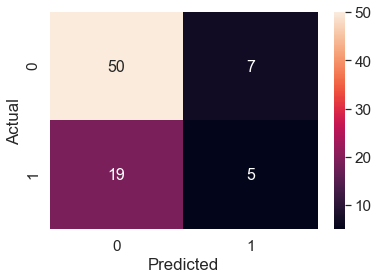

Wall time: 3.2 s


In [13]:
%%time
rf = RandomForestClassifier(n_estimators = 2000, max_features = 'auto', bootstrap = True)
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)
conf_mat = pd.DataFrame(confusion_matrix(Y_test, y_pred))
sns.set(font_scale=1.4) # for label size
plot = sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}) # font size
plot.set(xlabel='Predicted', ylabel='Actual')
plt.show()

In [14]:
df_feature_importance = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance

,feature importance
H,0.109793
TA,0.078984
NP,0.077089
NASA,0.064021
EM,0.062189
AV,0.058544
Task,0.050308
DWR,0.045575
TWR,0.043144
NT,0.042179


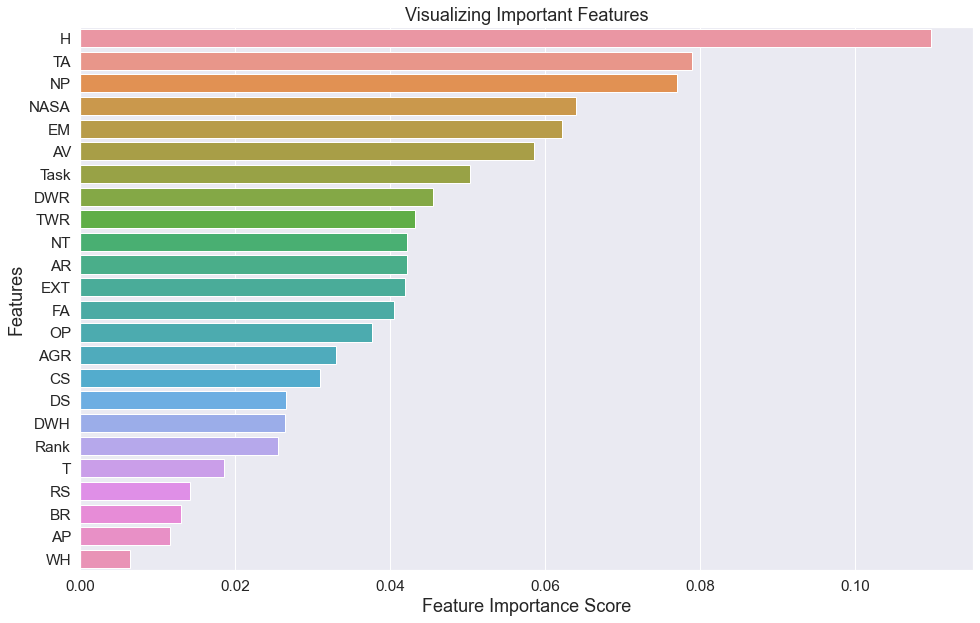

In [15]:
%matplotlib inline
feature_imp = pd.Series(rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
# Creating a bar plot
plt.figure(figsize=(16, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score', fontsize=18)
plt.ylabel('Features', fontsize=18)
plt.title("Visualizing Important Features", fontsize=18)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
# plt.legend()
plt.show()

In [20]:
df_features = imputed_df[['H', 'TA', 'NP', 'NASA', 'AV', 'Task', 'DWR', 'TWR', 'AR', 'EXT', 'FA', 'OP', 'AGR', 'CS', 'SR']]

<AxesSubplot:>

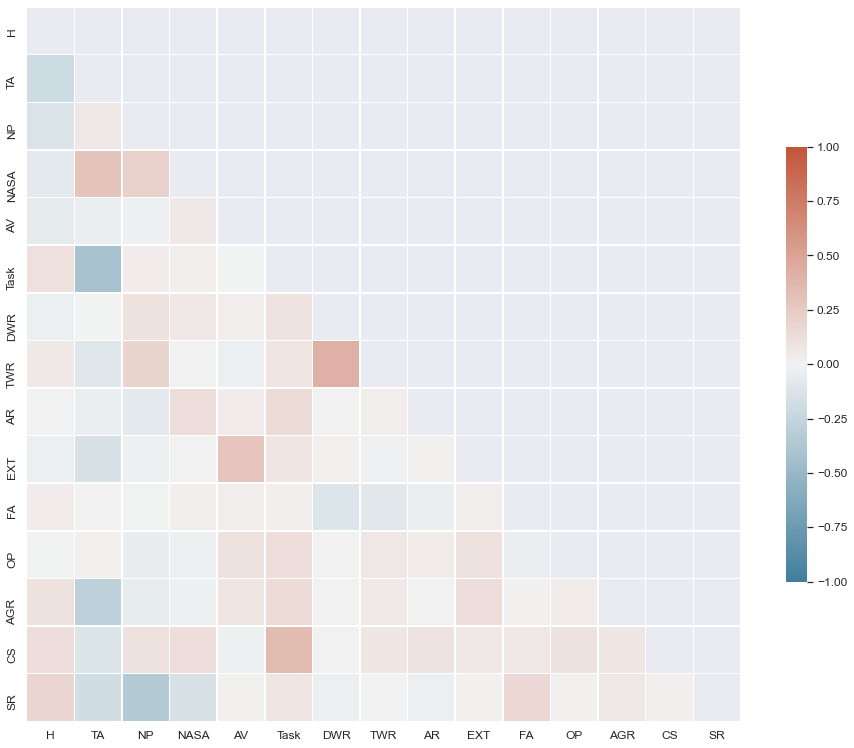

In [21]:
corr = df_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [22]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_features, df_features['SR']):
    strat_train_set = df_features.loc[train_index]
    strat_test_set = df_features.loc[test_index]

X_train = strat_train_set.drop('SR', axis=1)
Y_train = strat_train_set['SR'].copy()

X_test = strat_test_set.drop('SR', axis=1)
Y_test = strat_test_set['SR'].copy()

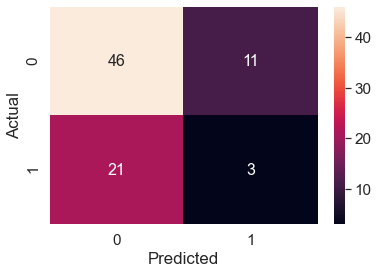

Wall time: 3.06 s


In [23]:
%%time
rf = RandomForestClassifier(n_estimators = 2000, max_features = 'auto', bootstrap = True)
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)
conf_mat = pd.DataFrame(confusion_matrix(Y_test, y_pred))
sns.set(font_scale=1.4) # for label size
plot = sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}) # font size
plot.set(xlabel='Predicted', ylabel='Actual')
plt.show()